In [192]:
import jupyter_black

jupyter_black.load()

# Standard Library
import itertools
import warnings
from datetime import datetime, timedelta

# Numerical Analysis
import numpy as np
import pandas as pd

# Plotting
import matplotlib.pyplot as plt
from pandas.plotting import lag_plot
import seaborn as sns

%matplotlib inline

# Statsmodels
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tools.sm_exceptions import ConvergenceWarning
from statsmodels.stats.outliers_influence import variance_inflation_factor


color = sns.color_palette()
sns.set_style("darkgrid")

import warnings


def ignore_warn(*args, **kwargs):
    pass


warnings.warn = ignore_warn


import os

os.chdir("/Users/66789/Documents/GitHub/aag-bain-f2fw/")
datafile = "data/230428 trucking2303_shared with AAG_color.xlsx"

<IPython.core.display.Javascript object>

## Reading the Data
Dependent variables: 
* Total TL: Contract Rate (exc. FSC, SA)
* Total TL: Spot Rate (exc. FSC, SA)

Independent variables:
* Active Truck Utilization
* Total Truck Loading
* Class 8 Truck Net Orders, US/CAN (only for Monthly view)
* Driver Labor Index
* Truck Transportation Employment (000's) (only for Monthly view)
* Real GDP
* CPI Index
* Three months T-Bill Rate
* National Avg. Diesel Fuel Price ($/Gal)

In [185]:
def read_data(freq: str):
    df = pd.read_excel(datafile, sheet_name=freq).T.reset_index(drop=True)
    new_header = df.iloc[1]  # grab the first row for the header
    df = df[3:]  # take the data less the header row
    df.columns = new_header  # set the header row as the df header
    df.drop(["Label: (SA = seasonally adjusted)"], axis=1, inplace=True)
    df = df.loc[:, df.columns.notna()]
    df = df.loc[:, ~df.columns.str.startswith("TCI Component")]
    df = df.loc[:, ~df.columns.str.startswith("Unnamed")]

    df.dropna(axis=0, how="all", inplace=True)
    df = df.apply(pd.to_numeric, downcast="float", errors="coerce")

    if freq == "QUARTERLY":
        df["Date"] = pd.date_range("2000-01-01", "2025-12-01", freq="QS")
        # df["Year"] = df["Date"].dt.year
        # df["Quarter"] = df["Date"].dt.quarter
    if freq == "MONTHLY":
        df["Date"] = pd.date_range("2000-01-01", "2025-01-01", freq="MS")
        # df["Year"] = df["Date"].dt.year
        # df["Month"] = df["Date"].dt.month

    df.dropna(inplace=True)
    df.set_index("Date", inplace=True)
    return df


df_quarterly = read_data("QUARTERLY")
df_monthly = read_data("MONTHLY")

spot_col = "Total TL: Spot Rate (exc. FSC, SA)"
contract_col = "Total TL: Contract Rate (exc. FSC, SA)"


print("Quarterly Data:")
display(df_quarterly.sample(5))
display(df_quarterly.describe())
print("*******")
print("Monthly Data:")
display(df_monthly.sample(5))
display(df_monthly.describe())

Quarterly Data:


1           Active Truck Utilization (SA)  Total Truck Loadings (SA)  \
Date                                                                   
2013-07-01                       0.903085               1.598930e+08   
2017-07-01                       1.000000               1.877954e+08   
2008-01-01                       0.880277               1.716240e+08   
2012-07-01                       0.892086               1.552439e+08   
2013-04-01                       0.882500               1.597975e+08   

1           Total TL: Spot Rate (exc. FSC, SA)  \
Date                                             
2013-07-01                          107.360580   
2017-07-01                          116.139412   
2008-01-01                          100.000000   
2012-07-01                          103.764847   
2013-04-01                          102.433960   

1           Total TL: Contract Rate (exc. FSC, SA)  \
Date                                                 
2013-07-01                              106.752007   
2017-07-01                              116.113373   
2008-01-01                              100.000000   
2012-07-01                              106.908600   
2013-04-01                              105.527420   

1           Driver Labor Index (1992=100, SA)  \
Date                                            
2013-07-01                         124.975998   
2017-07-01                         125.636948   
2008-01-01                         116.568710   
2012-07-01                         125.340988   
2013-04-01                         125.186035   

1           Truck Driver Pressure Index (0 = Neutral, SA)   Real GDP  \
Date                                                                   
2013-07-01                                      -0.557026  16594.743   
2017-07-01                                      11.269815  18127.994   
2008-01-01                                      -3.301321  15702.906   
2012-07-01                                      -0.911448  16282.151   
2013-04-01                                      -1.740746  16464.402   

1           CPI Index  3 Month T-Bill Rate, %  \
Date                                            
2013-07-01   2.333000                0.033333   
2017-07-01   2.452870                1.056667   
2008-01-01   2.127697                2.090000   
2012-07-01   2.298410                0.103333   
2013-04-01   2.320450                0.050000   

1           National Avg. Diesel Fuel Price ($/Gal.)  
Date                                                  
2013-07-01                                  3.910667  
2017-07-01                                  2.625333  
2008-01-01                                  3.522000  
2012-07-01                                  3.941333  
2013-04-01                                  3.883000

1      Active Truck Utilization (SA)  Total Truck Loadings (SA)  \
count                      72.000000               7.200000e+01   
mean                        0.906564               1.757162e+08   
std                         0.049938               1.821928e+07   
min                         0.818753               1.421712e+08   
25%                         0.872820               1.584282e+08   
50%                         0.892210               1.786864e+08   
75%                         0.933749               1.925471e+08   
max                         1.000000               1.992374e+08   

1      Total TL: Spot Rate (exc. FSC, SA)  \
count                           72.000000   
mean                           112.676071   
std                             17.677216   
min                             77.902023   
25%                            103.122383   
50%                            108.940704   
75%                            119.990999   
max                            162.431305   

1      Total TL: Contract Rate (exc. FSC, SA)  \
count                               72.000000   
mean                               120.851532   
std                                 18.209970   
min                                 95.654587   
25%                                105.698406   
50%                                114.899826   
75%                                139.079742   
max                                156.782104   

1      Driver Labor Index (1992=100, SA)  \
count                          72.000000   
mean                          125.431396   
std                             2.516893   
min                           116.568710   
25%                           124.481634   
50%                           125.208519   
75%                           126.535439   
max                           130.137955   

1      Truck Driver Pressure Index (0 = Neutral, SA)      Real GDP  CPI Index  \
count                                      72.000000     72.000000  72.000000   
mean                                       -0.775184  17929.576722   2.546312   
std                                         6.228236   1817.148746   0.355462   
min                                       -11.974460  15161.772000   2.123777   
25%                                        -4.887067  16275.044750   2.295827   
50%                                        -1.908866  17768.524500   2.429867   
75%                                         3.633075  19576.334473   2.698610   
max                                        11.560026  21040.896484   3.358075   

1      3 Month T-Bill Rate, %  National Avg. Diesel Fuel Price ($/Gal.)  
count               72.000000                                 72.000000  
mean                 1.324479                                  3.435805  
std                  1.753668                                  0.759784  
min                  0.013333                                  2.077000  
25%                  0.065833                                  2.865083  
50%                  0.275000                                  3.439833  
75%                  2.080000                                  3.981917  
max                  5.419121                                  5.481667

*******
Monthly Data:


1           Active Truck Utilization (SA)  Total Truck Loadings (SA)  \
Date                                                                   
2009-12-01                       0.853450               4.692283e+07   
2020-10-01                       0.991416               6.234888e+07   
2015-10-01                       0.833841               5.430901e+07   
2022-10-01                       0.898916               6.546370e+07   
2020-05-01                       0.847174               5.692811e+07   

1           Total TL: Spot Rate (exc. FSC, SA)  \
Date                                             
2009-12-01                           85.603165   
2020-10-01                          142.751785   
2015-10-01                          104.138474   
2022-10-01                          110.006798   
2020-05-01                           93.084694   

1           Total TL: Contract Rate (exc. FSC, SA)  \
Date                                                 
2009-12-01                               96.843636   
2020-10-01                              129.682556   
2015-10-01                              114.849800   
2022-10-01                              147.857254   
2020-05-01                              119.967339   

1           Driver Labor Index (1992=100, SA)      Real GDP   CPI Index  \
Date                                                                      
2009-12-01                         124.497879  15414.258828  217.347000   
2020-10-01                         125.133820  19018.879776  260.286011   
2015-10-01                         123.541084  17441.978000  237.733002   
2022-10-01                         126.767273  20145.297345  297.987000   
2020-05-01                         123.924683  17132.973995  255.867996   

1           3 Month T-Bill Rate, %  National Avg. Diesel Fuel Price ($/Gal.)  \
Date                                                                           
2009-12-01                0.054545                                     2.745   
2020-10-01                0.100476                                     2.389   
2015-10-01                0.015238                                     2.519   
2022-10-01                3.717000                                     5.211   
2020-05-01                0.127500                                     2.392   

1           Truck Transportation Employment (000's)  \
Date                                                  
2009-12-01                                   1241.0   
2020-10-01                                   1470.0   
2015-10-01                                   1453.0   
2022-10-01                                   1605.0   
2020-05-01                                   1434.0   

1           Class 8 Truck Net Orders, US/CAN  
Date                                          
2009-12-01                            8973.0  
2020-10-01                           36912.0  
2015-10-01                           22634.0  
2022-10-01                           39850.0  
2020-05-01                            6241.0

1      Active Truck Utilization (SA)  Total Truck Loadings (SA)  \
count                     181.000000               1.810000e+02   
mean                        0.912227               5.729220e+07   
std                         0.050842               5.797451e+06   
min                         0.813157               4.692283e+07   
25%                         0.877142               5.188737e+07   
50%                         0.894812               5.552920e+07   
75%                         0.954212               6.368284e+07   
max                         1.000000               6.632599e+07   

1      Total TL: Spot Rate (exc. FSC, SA)  \
count                          181.000000   
mean                           111.342888   
std                             18.551622   
min                             76.620911   
25%                            101.614578   
50%                            107.496033   
75%                            117.953949   
max                            169.923569   

1      Total TL: Contract Rate (exc. FSC, SA)  \
count                              181.000000   
mean                               116.300308   
std                                 16.113720   
min                                 95.407272   
25%                                104.789543   
50%                                113.221802   
75%                                125.512939   
max                                157.509750   

1      Driver Labor Index (1992=100, SA)      Real GDP   CPI Index  \
count                         181.000000    181.000000  181.000000   
mean                          124.756020  17421.618757  241.884827   
std                             2.006113   1516.503317   21.552265   
min                           116.624504  15160.877573  211.397995   
25%                           124.398468  15976.761575  226.750000   
50%                           125.136353  17406.874079  237.498001   
75%                           125.620827  18726.461617  255.158997   
max                           128.396576  20260.513248  300.536011   

1      3 Month T-Bill Rate, %  National Avg. Diesel Fuel Price ($/Gal.)  \
count              181.000000                                181.000000   
mean                 0.662737                                  3.311160   
std                  0.947643                                  0.776748   
min                  0.011429                                  1.998000   
25%                  0.052381                                  2.681000   
50%                  0.149500                                  3.130000   
75%                  1.074762                                  3.885000   
max                  4.537500                                  5.754000   

1      Truck Transportation Employment (000's)  \
count                               181.000000   
mean                               1422.248657   
std                                  96.706886   
min                                1235.000000   
25%                                1356.000000   
50%                                1444.000000   
75%                                1492.000000   
max                                1615.000000   

1      Class 8 Truck Net Orders, US/CAN  
count                        181.000000  
mean                       19765.546875  
std                        10378.994141  
min                         3688.000000  
25%                        12574.000000  
50%                        17915.000000  
75%                        23182.000000  
max                        50632.000000

<IPython.core.display.Javascript object>

## Correlations

In [173]:
def correlation_check(df: pd.DataFrame) -> None:
    """
    Plots a Pearson Correlation Heatmap.
    ---
    Args:
        df (pd.DataFrame): dataframe to plot

    Returns: None
    """

    # Figure
    fig, ax = plt.subplots(figsize=(16, 12), facecolor="w")
    correlations_df = df.corr(method="pearson", min_periods=1)
    sns.heatmap(correlations_df, cmap="Blues", annot=True, linewidth=0.1)

    # Labels
    ax.set_title("Pearson Correlation Heatmap", fontsize=15, pad=10)
    ax.set_facecolor(color="white")

<IPython.core.display.Javascript object>

Quarterly Correlation Matrix


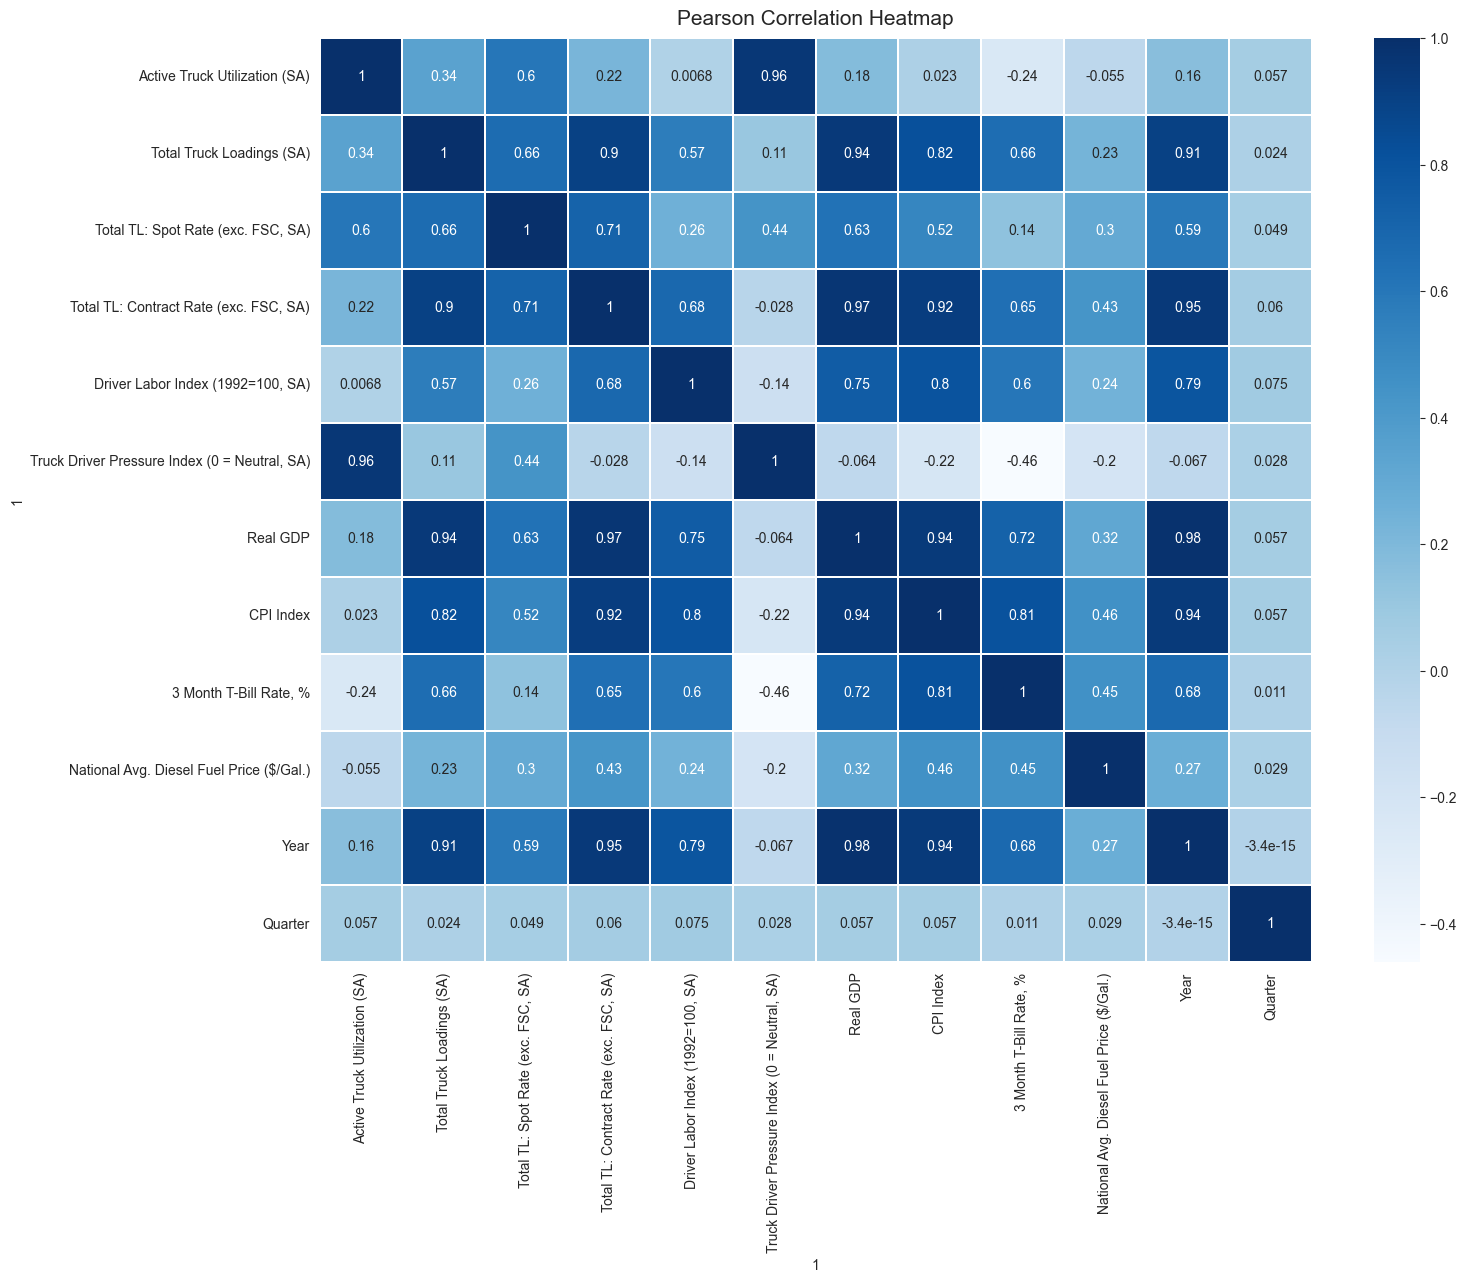

<IPython.core.display.Javascript object>

In [180]:
print("Quarterly Correlation Matrix")
correlation_check(df_quarterly)  # .drop([spot_col, contract_col], axis=1))

#### Quarterly Observations
* Spot Rate is highly correlated with Contract Rate
* Contract Rate is highly correlated with Total Truck Loadings (SA), Real GDP, CPI Index, Year
* Active Truck Utilization (SA) is highly correlated with Truck Driver Pressure Index 
* Total Truck Loadings (SA) is highly correlated with Real GDP, CPI Index, and Year
* Real GDP is highly correlated with Driver Labor Index, Total Truck Loadings (SA), Contract Rate, CPI Index, Year
* 3 Month T-Bill Rate, % is highly correlated with CPI Index and Real GDP

* Try Active Truck Utilization (SA), Active Truck Loadings (SA), Driver Labor Index (1992=100, SA), Real GDP/CPI Index, 3 Month T-Bill Rate, %, National Avg. Diesel Fuel Price ($/Gal.)

Monthly Correlation Matrix


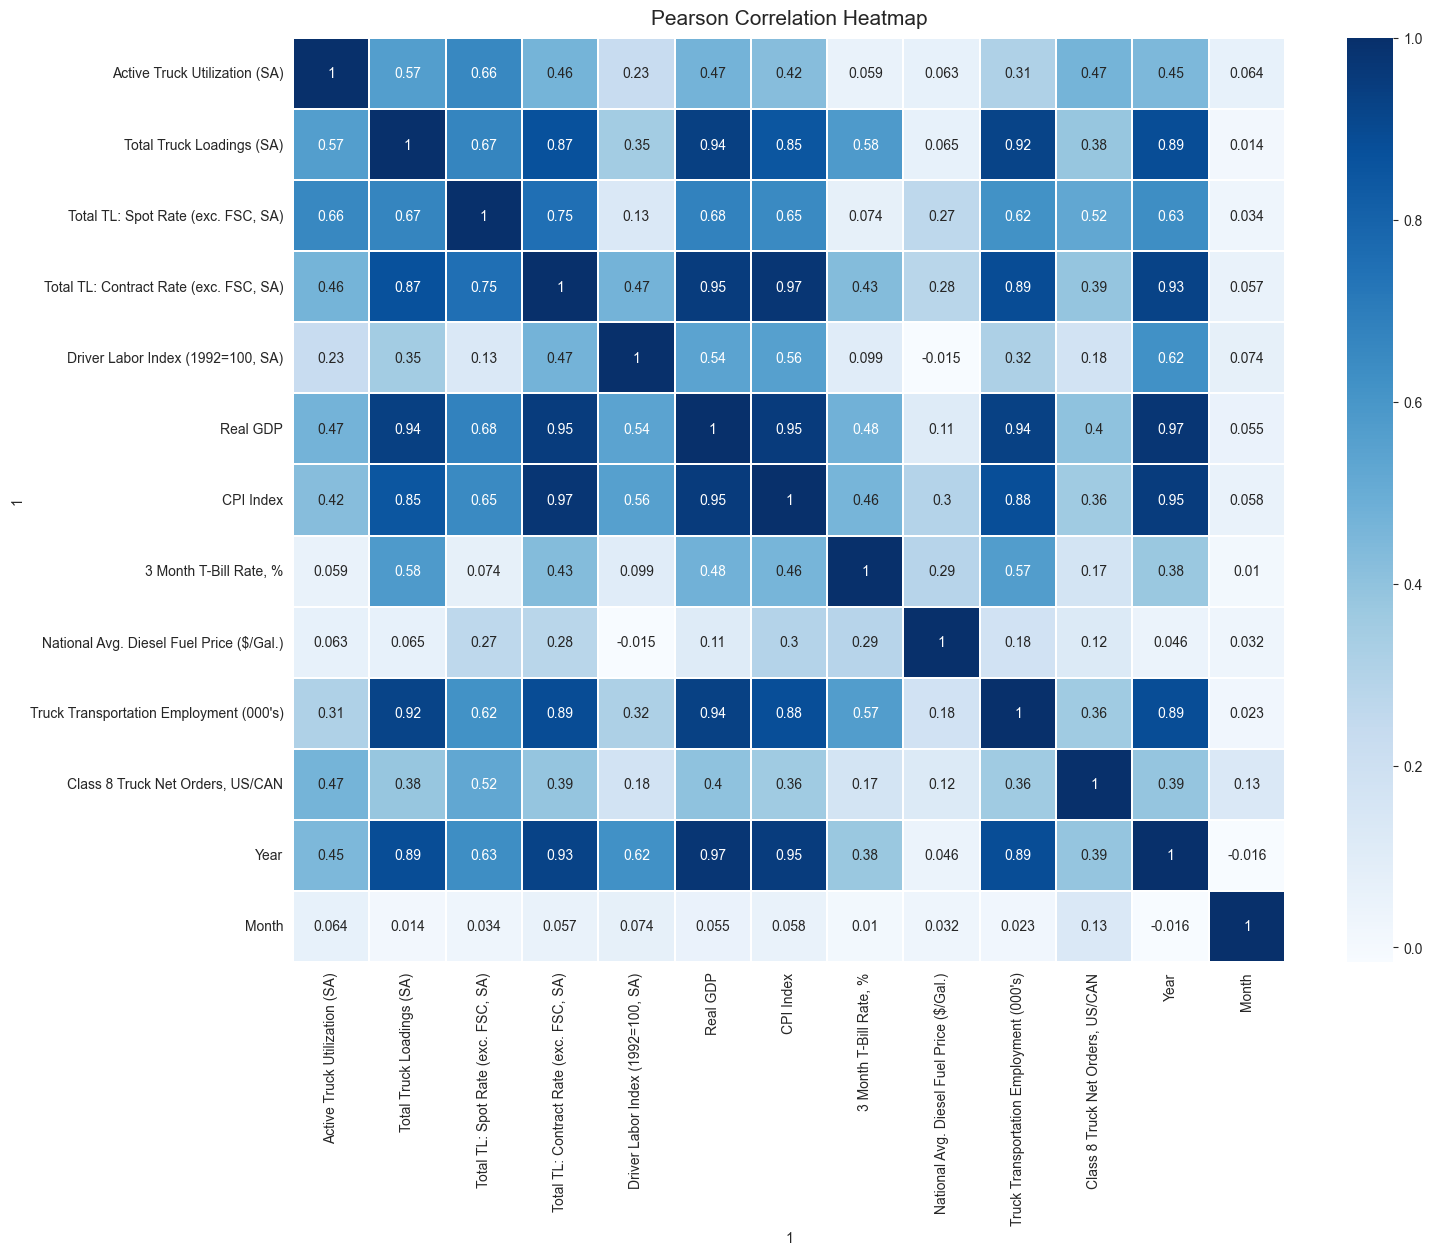

<IPython.core.display.Javascript object>

In [179]:
print("Monthly Correlation Matrix")
correlation_check(df_monthly)# .drop([spot_col, contract_col], axis=1))

#### Monthly Observations
* Spot Rate is highly correlated with Contract Rate
* Contract Rate is highly correlated with Total Truck Loadings (SA), Real GDP, CPI Index, Year, Truck Transportation Employment (000's)
* Total Truck Loadings (SA) is highly correlated with Real GDP, CPI Index, Year, Truck Transportation Employment (000's)
* Real GDP is highly correlated with Total Truck Loadings (SA), Contract Rate, CPI Index, Year, Truck Transportation Employment (000's)
* Truck Transportation Employment (000's) is highly correlated with Total Truck Loadings (SA), Real GDP, CPI Index, Year


* Try Active Truck Utilization (SA), Active Truck Loadings (SA), Class 8 Truck New Orders, US/CAN, Driver Labor Index (1992=100, SA), Real GDP/CPI Index, 3 Month T-Bill Rate, %, National Avg. Diesel Fuel Price ($/Gal.)

## EDA
* Missing values
* Correlations
* Time series analysis

In [107]:
train_missing = (df.isnull().sum() / len(df)) * 100
train_missing = train_missing.drop(train_missing[train_missing == 0].index).sort_values(
    ascending=False
)
missing_data = pd.DataFrame({"Missing Percentage": train_missing})
missing_data

Empty DataFrame
Columns: [Missing Percentage]
Index: []

<IPython.core.display.Javascript object>

In [187]:
# timeseries_heatmap(dataframe=df, entity_column='Site Num', sortby='Date')

profile = ProfileReport(df_quarterly, tsmode=True, sortby="Date")
profile.to_file("quarterly_profile_report.html")

profile = ProfileReport(df_monthly, tsmode=True, sortby="Date")
profile.to_file("monthly_profile_report.html")

Export report to file: 100%|██████████| 1/1 [00:00<00:00, 102.72it/s]


<IPython.core.display.Javascript object>

## Non-stationary Variables
### Quarterly
* Non-stationary Predictants: Spot and Contract Rates
* Non-stationary Predictors: Total Truck Loadings (SA), Driver Labor Index (1992=100, SA), Real GDP, CPI Index, 3 Month T-Bill Rate, National Avg. Diesel Fuel Price, Active Truck Utilization (SA)
* Seasonal Predictors: Active Truck Utilization (SA)

### Monthly
* Non-stationary Predictants: Spot and Contract Rates
* Non-stationary Predictors: Total Truck Loadings (SA), Real GDP, CPI Index, 3 Month T-Bill Rate, National Avg. Diesel Fuel Price, <s>Active Truck Utilization (SA)</s>

In [188]:
train_spot = df_quarterly[["Total TL: Spot Rate (exc. FSC, SA)"]].dropna()
train_spot.index.freq = "QS"
train_spot.index

train_contract = df_quarterly[["Total TL: Contract Rate (exc. FSC, SA)"]].dropna()
train_contract.index.freq = "QS"
train_contract.index

DatetimeIndex(['2008-01-01', '2008-04-01', '2008-07-01', '2008-10-01',
               '2009-01-01', '2009-04-01', '2009-07-01', '2009-10-01',
               '2010-01-01', '2010-04-01', '2010-07-01', '2010-10-01',
               '2011-01-01', '2011-04-01', '2011-07-01', '2011-10-01',
               '2012-01-01', '2012-04-01', '2012-07-01', '2012-10-01',
               '2013-01-01', '2013-04-01', '2013-07-01', '2013-10-01',
               '2014-01-01', '2014-04-01', '2014-07-01', '2014-10-01',
               '2015-01-01', '2015-04-01', '2015-07-01', '2015-10-01',
               '2016-01-01', '2016-04-01', '2016-07-01', '2016-10-01',
               '2017-01-01', '2017-04-01', '2017-07-01', '2017-10-01',
               '2018-01-01', '2018-04-01', '2018-07-01', '2018-10-01',
               '2019-01-01', '2019-04-01', '2019-07-01', '2019-10-01',
               '2020-01-01', '2020-04-01', '2020-07-01', '2020-10-01',
               '2021-01-01', '2021-04-01', '2021-07-01', '2021-10-01',
      

<IPython.core.display.Javascript object>

Contract rate


<AxesSubplot: xlabel='1-Date', ylabel='Date'>

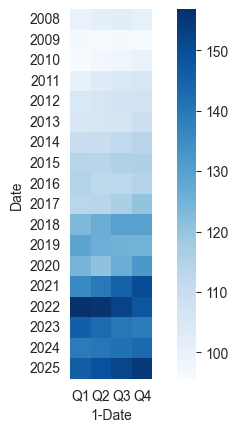

<IPython.core.display.Javascript object>

In [181]:
print("Contract rate")
sns.heatmap(
    pd.pivot_table(
        data=train_contract,
        index=train_contract.index.year,
        columns=train_contract.index.quarter,
    ),
    square=True,
    cmap="Blues",
    xticklabels=["Q1", "Q2", "Q3", "Q4"],
)

Spot rate


<AxesSubplot: xlabel='1-Date', ylabel='Date'>

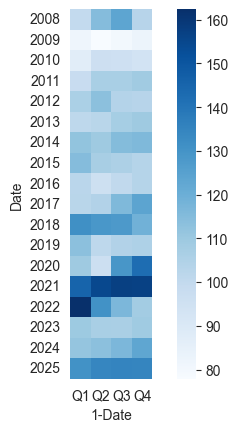

<IPython.core.display.Javascript object>

In [182]:
print("Spot rate")
sns.heatmap(
    pd.pivot_table(
        data=train_spot, index=train_spot.index.year, columns=train_spot.index.quarter
    ),
    square=True,
    cmap="Blues",
    xticklabels=["Q1", "Q2", "Q3", "Q4"],
)

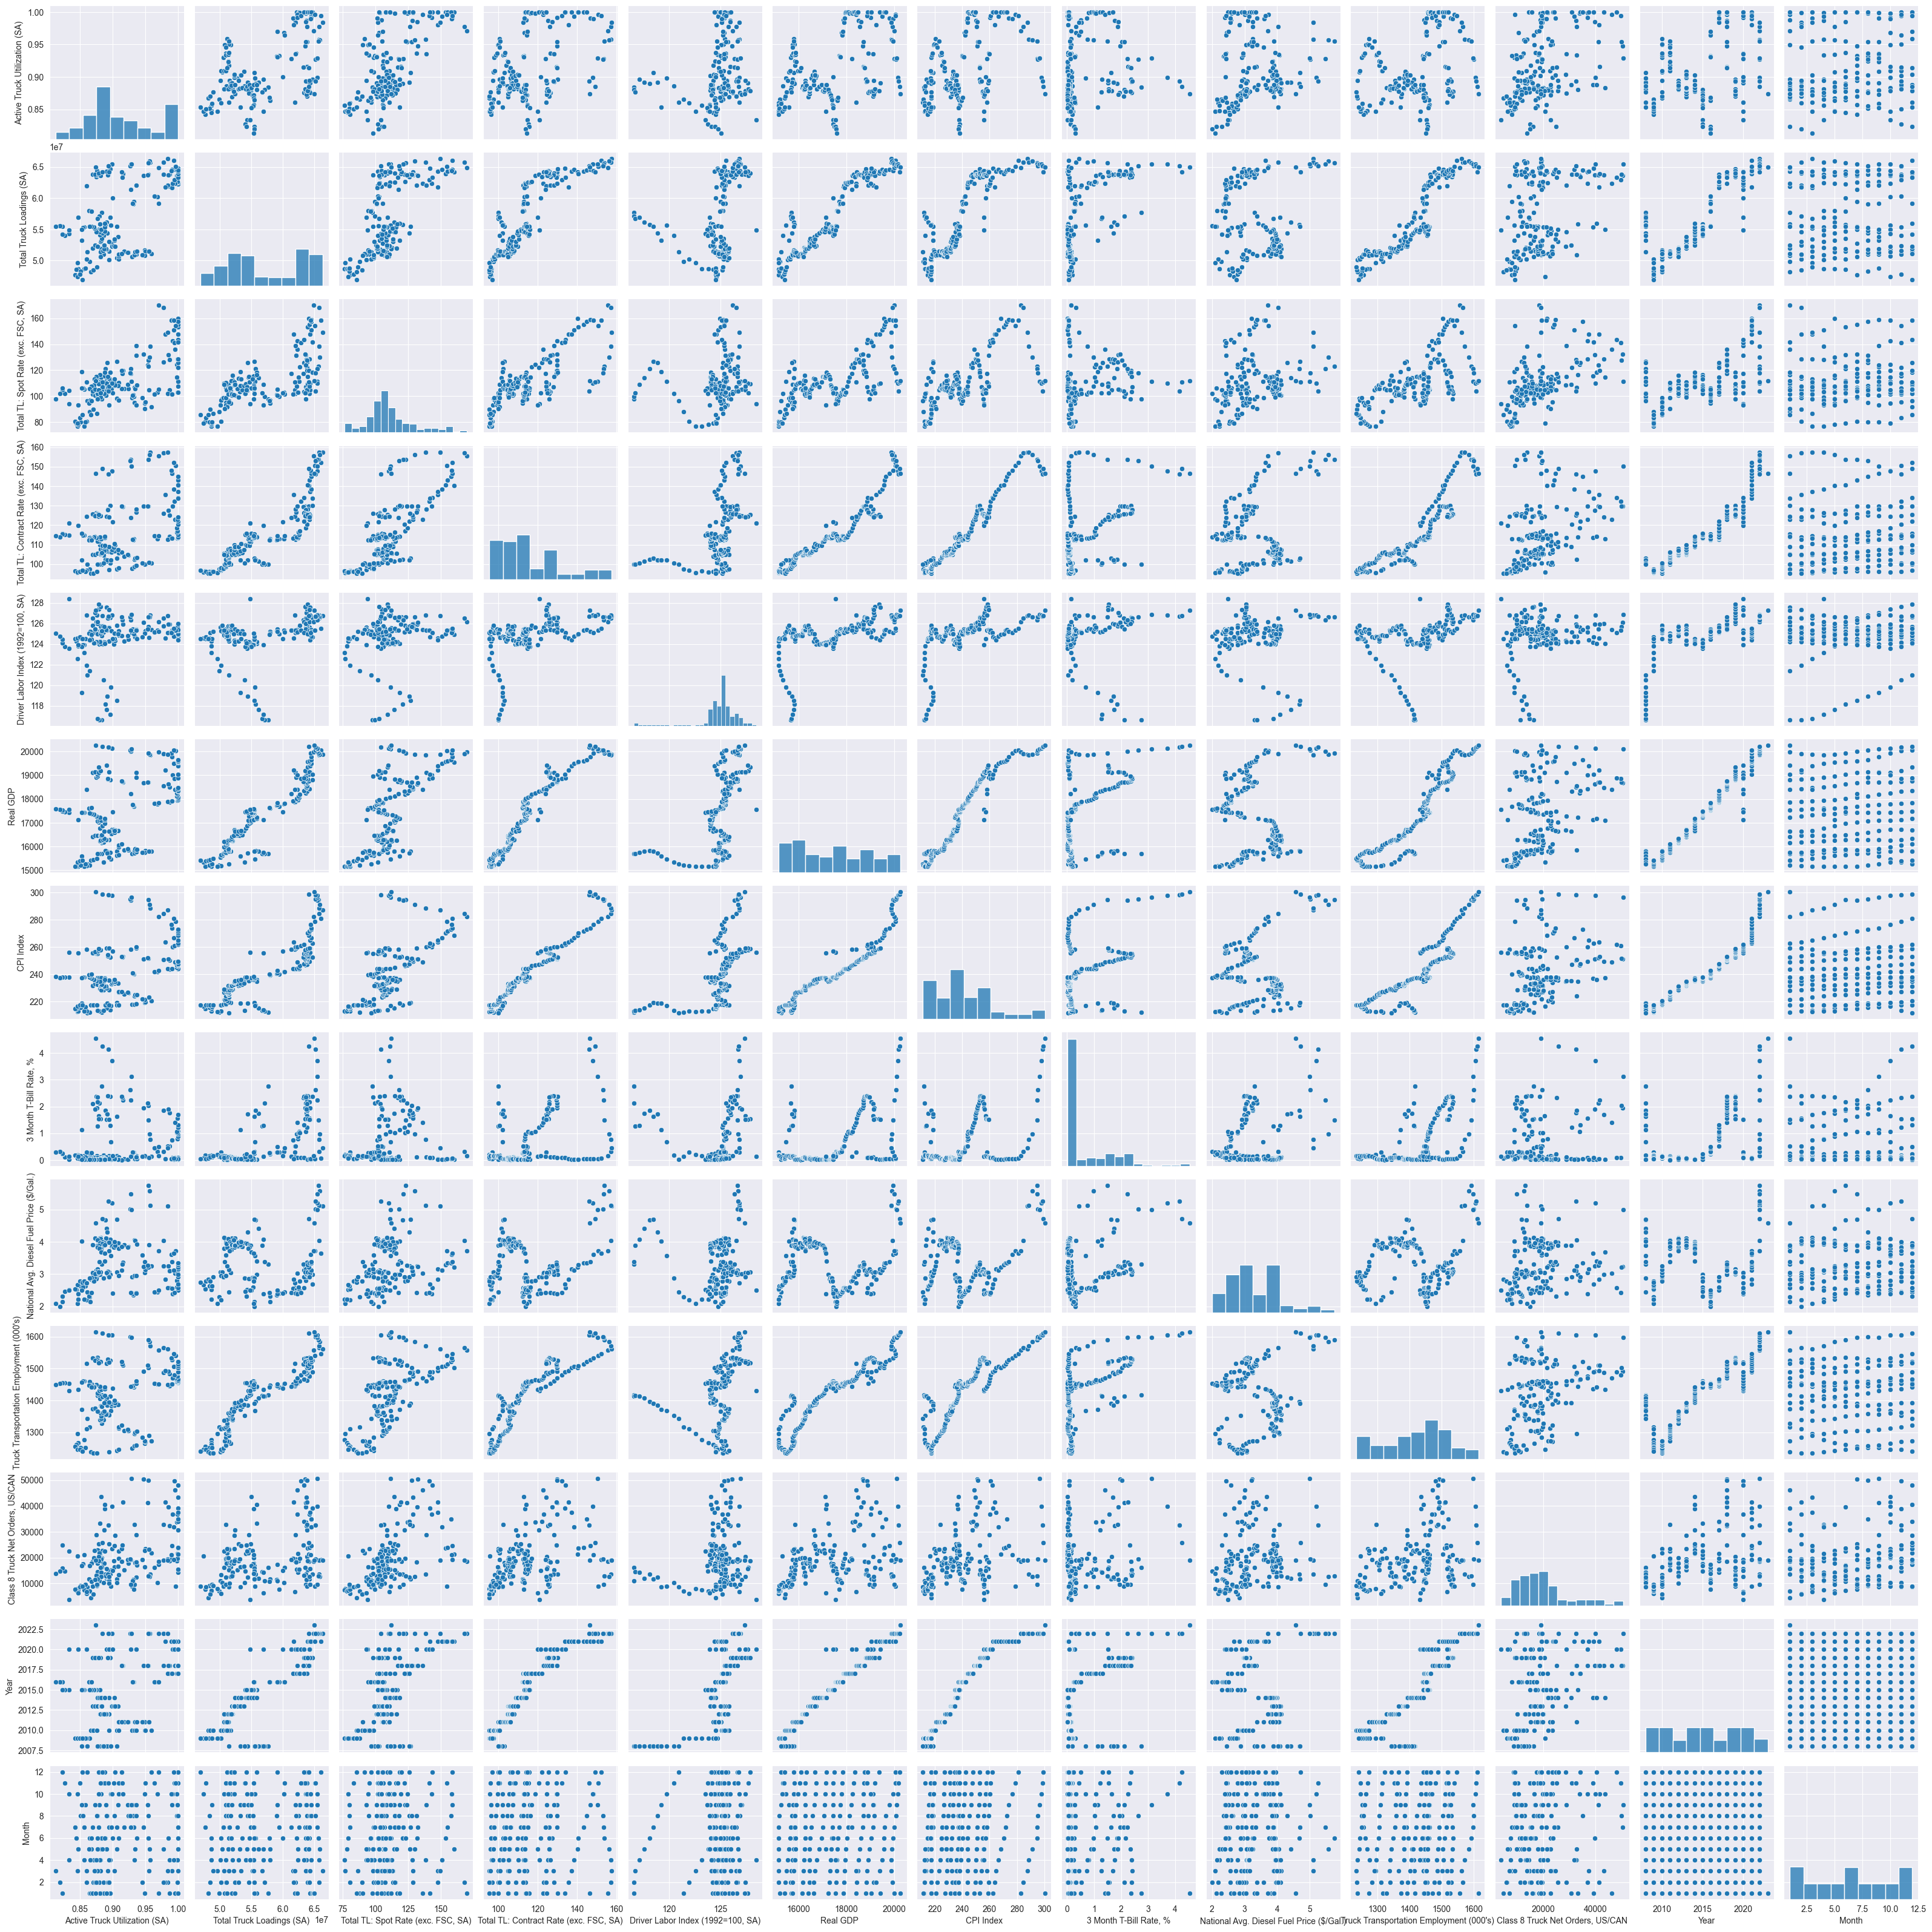

<IPython.core.display.Javascript object>

In [183]:
sns.pairplot(df_monthly)

In [195]:
X = df_monthly.drop([contract_col, spot_col], axis=1)
y = contract_col
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

vif["features"] = X.columns

# print VIF values

print(vif)

    VIF Factor                                  features
0  1593.937457             Active Truck Utilization (SA)
1  4434.087469                 Total Truck Loadings (SA)
2  1995.776453         Driver Labor Index (1992=100, SA)
3  7590.362293                                  Real GDP
4  2978.246109                                 CPI Index
5     4.553609                    3 Month T-Bill Rate, %
6    47.756930  National Avg. Diesel Fuel Price ($/Gal.)
7  3138.703668   Truck Transportation Employment (000's)
8     7.557398          Class 8 Truck Net Orders, US/CAN


<IPython.core.display.Javascript object>

In [196]:
from sklearn.feature_selection import SelectKBest

from sklearn.feature_selection import f_regression

# define number of features to keep

k = 7

# perform feature selection

X_new = SelectKBest(f_regression, k=k).fit_transform(X, y)

# get feature names of selected features

selected_features = X.columns[SelectKBest(f_regression, k=k).fit(X, y).get_support()]

# print selected features

print(selected_features)

TypeError: Singleton array array('Total TL: Contract Rate (exc. FSC, SA)', dtype='<U38') cannot be considered a valid collection.

<IPython.core.display.Javascript object>

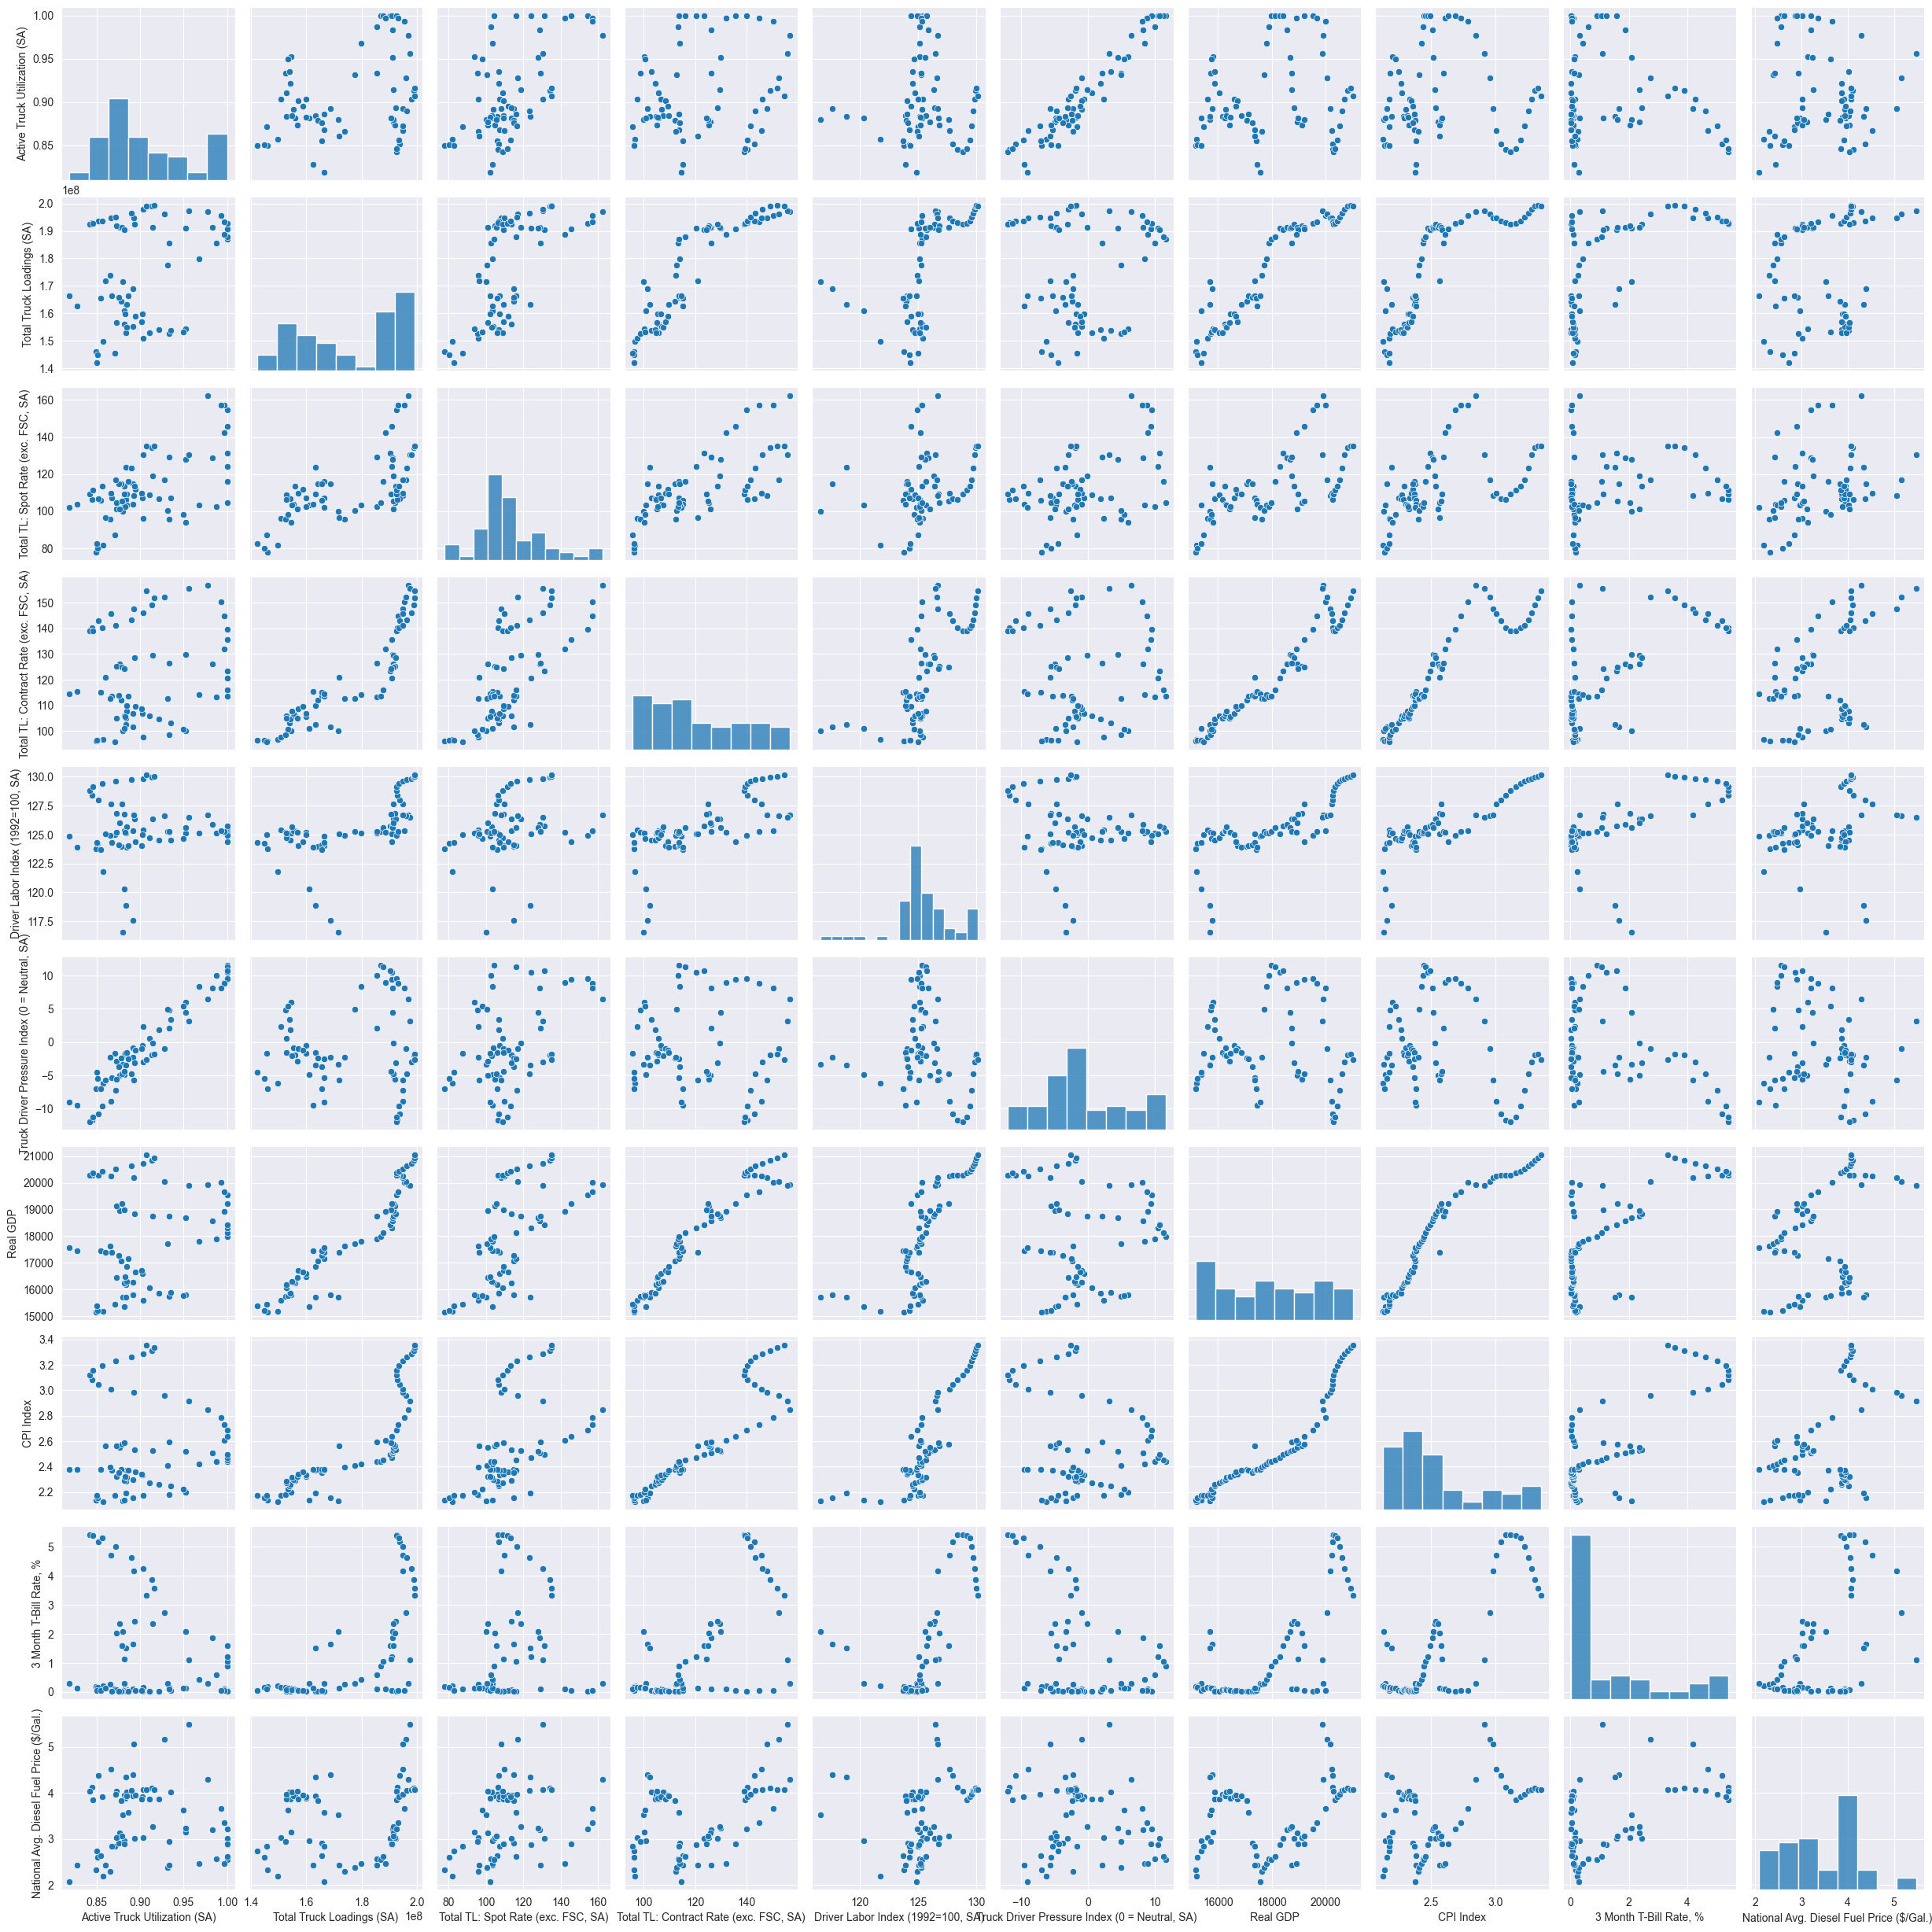

<IPython.core.display.Javascript object>

In [190]:
sns.pairplot(df_quarterly)

<AxesSubplot: xlabel='y(t)', ylabel='y(t + 1)'>

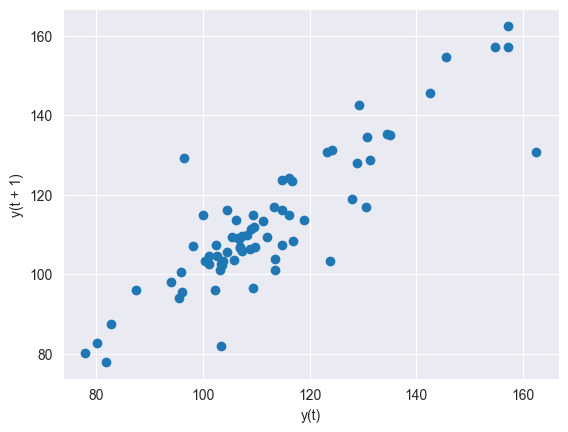

<IPython.core.display.Javascript object>

In [40]:
pd.plotting.lag_plot(train_spot["Total TL: Spot Rate (exc. FSC, SA)"], 1)

In [ ]:
pd.plotting.lag_plot(train_spot["Total TL: Spot Rate (exc. FSC, SA)"],4)

In [139]:
test_results = adfuller(df_monthly[spot_col])

print(f"ADF test statistic: {test_results[0]}")
print(f"p-value: {test_results[1]}")
print("Critical thresholds:")

for key, value in test_results[4].items():
    print(f"\t{key}: {value}")

ADF test statistic: -2.5749612893748637
p-value: 0.09828346683960365
Critical thresholds:
	1%: -3.4674201432469816
	5%: -2.877826051844538
	10%: -2.575452082332012


<IPython.core.display.Javascript object>

In [55]:
test_results = adfuller(df[contract_col])

print(f"ADF test statistic: {test_results[0]}")
print(f"p-value: {test_results[1]}")
print("Critical thresholds:")

for key, value in test_results[4].items():
    print(f"\t{key}: {value}")

ADF test statistic: 0.289842736085357
p-value: 0.9768736479547546
Critical thresholds:
	1%: -3.53692771987915
	5%: -2.907887369384766
	10%: -2.591493291015625


<IPython.core.display.Javascript object>

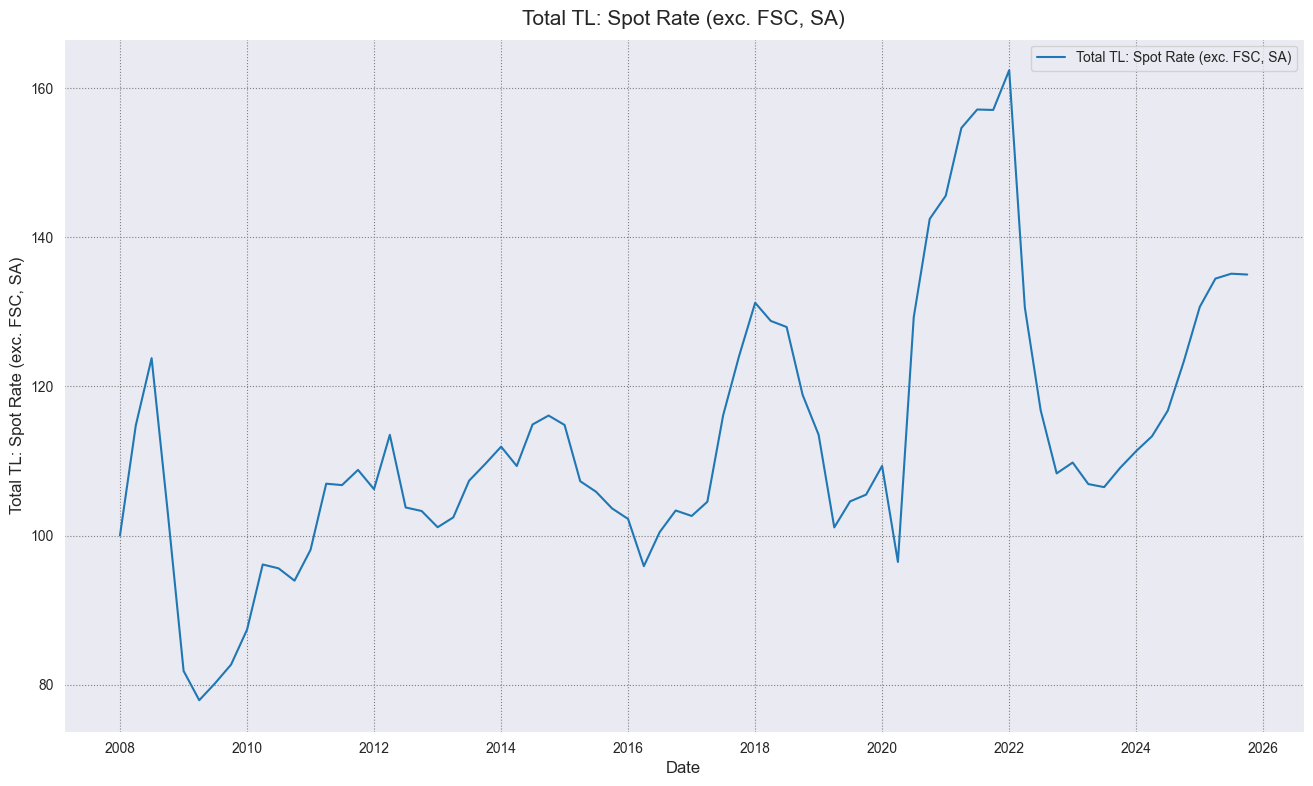

<IPython.core.display.Javascript object>

In [114]:
def target_rates(df: pd.DataFrame, target_col: str) -> None:
    """
    This function plots the rates over time.
    ---
    Args:
        df (pd.DataFrame): Dataframe contains the timeseries data
    Returns: None
    """

    # Figure
    fig, ax = plt.subplots(figsize=(16, 9), facecolor="w")
    ax.plot(df.index, df[target_col])

    # Labels
    ax.set_title(target_col, fontsize=15, pad=10)
    ax.set_ylabel(target_col, fontsize=12)
    ax.set_xlabel("Date", fontsize=12)

    # Grid & Legend
    plt.grid(linestyle=":", color="grey")
    plt.legend([target_col])
    plt.show()


target_rates(df, spot_col)

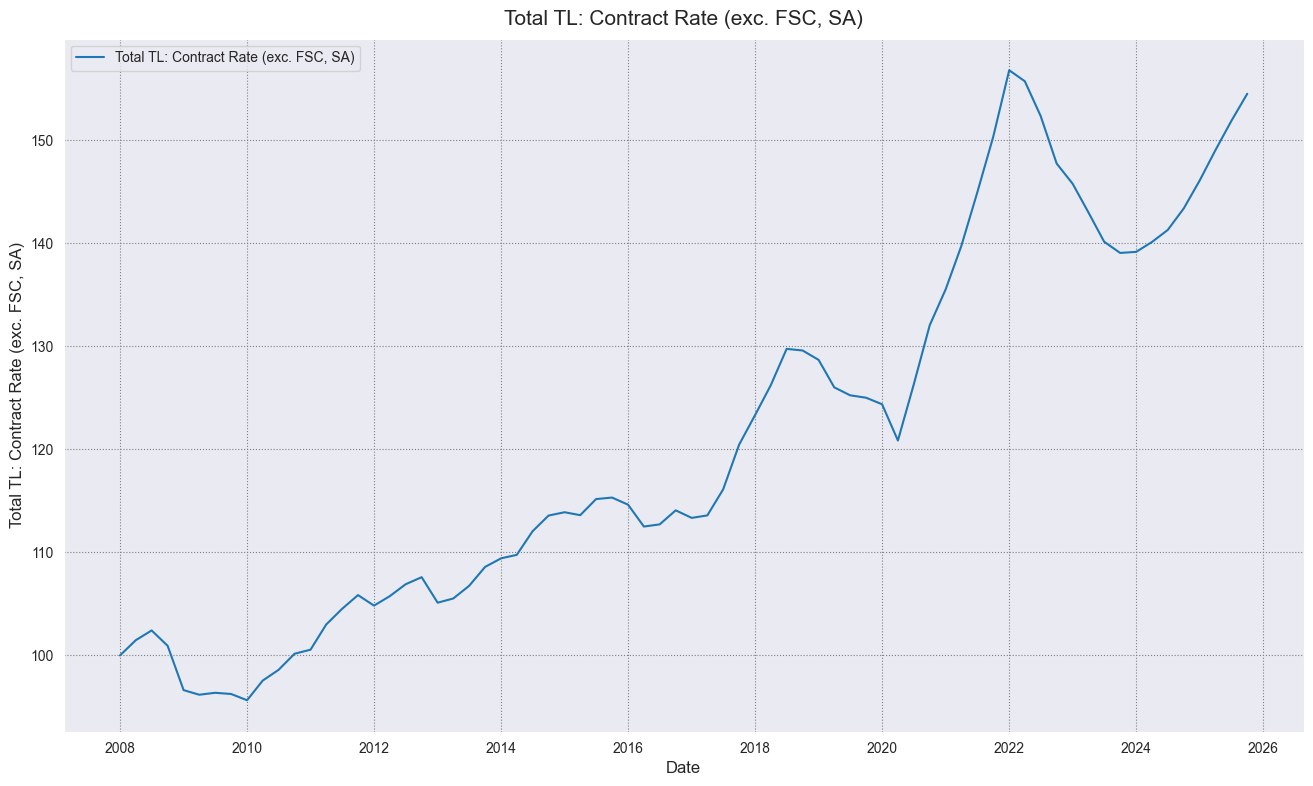

<IPython.core.display.Javascript object>

In [115]:
target_rates(df, contract_col)

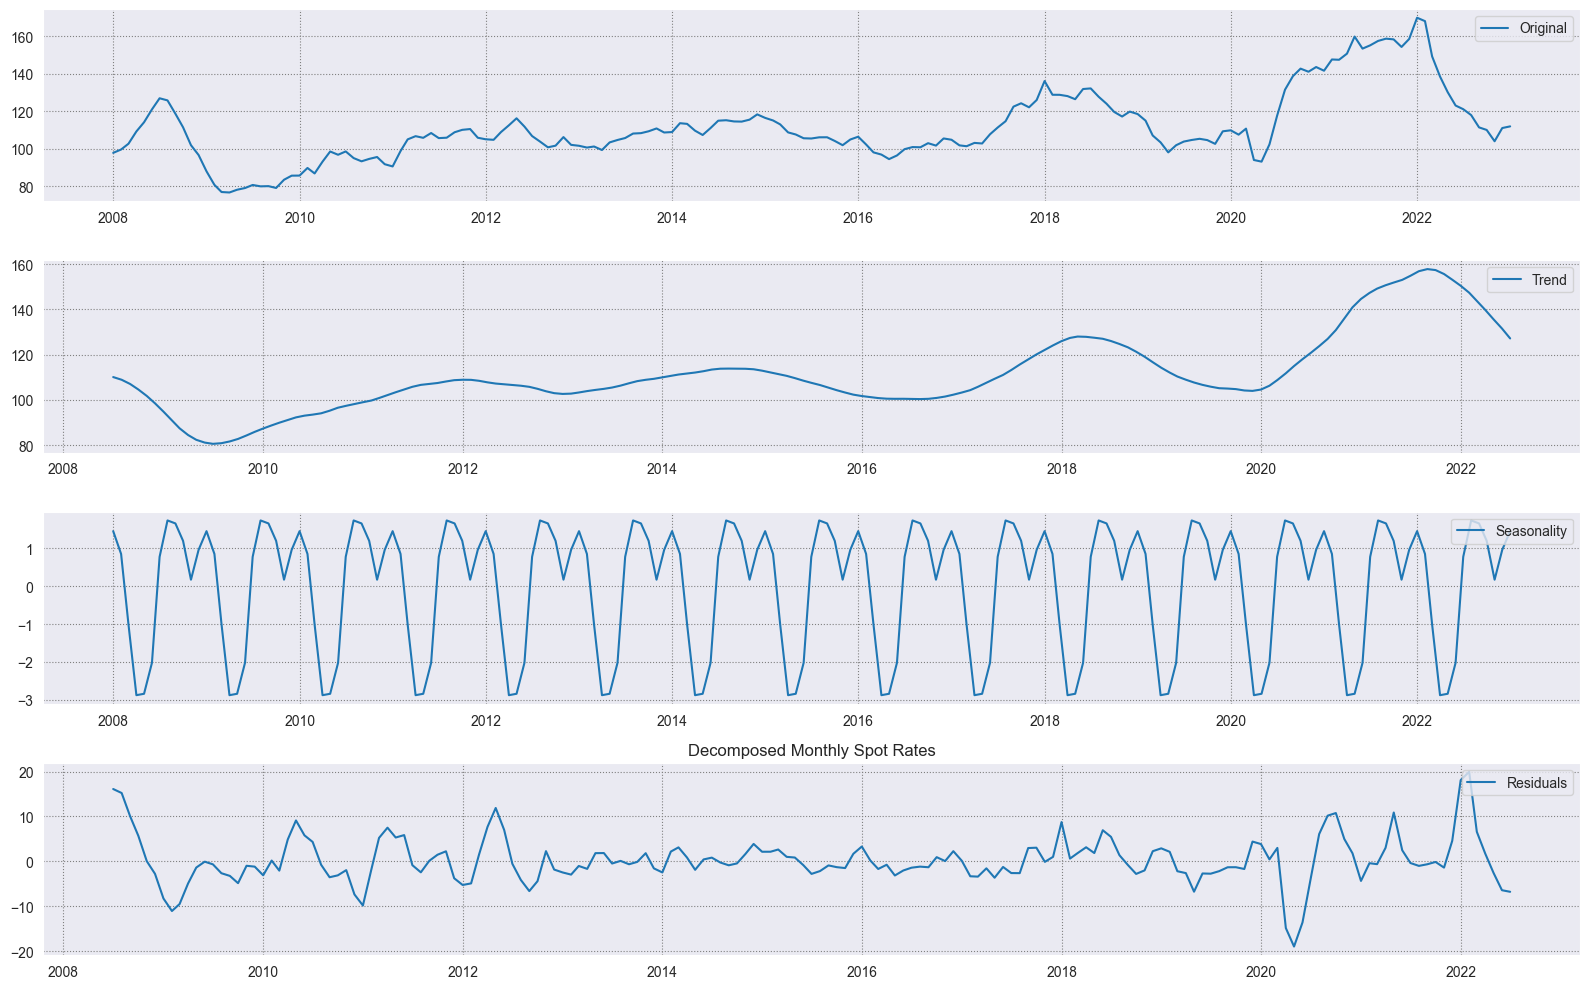

<IPython.core.display.Javascript object>

In [146]:
def decompose_series(df: pd.DataFrame, freq: str, target: str) -> None:
    """
    This function decomposes the time series
    into trend, seasonality and residuals.
    ---
    Args:
        df (pd.DataFrame): Dataframe that contains the timeseries data

    Returns: None
    """
    # Decomposition
    decomposition = seasonal_decompose(df)
    trend = decomposition.trend
    seasonal = decomposition.seasonal
    residual = decomposition.resid

    # Figure
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(16, 10), facecolor="w")

    ax1.plot(df, label="Original")
    ax2.plot(trend, label="Trend")
    ax3.plot(seasonal, label="Seasonality")
    ax4.plot(residual, label="Residuals")

    # Legend
    ax1.legend(loc="upper right")
    ax2.legend(loc="upper right")
    ax3.legend(loc="upper right")
    ax4.legend(loc="upper right")

    ax1.grid(linestyle=":", color="grey")
    ax2.grid(linestyle=":", color="grey")
    ax3.grid(linestyle=":", color="grey")
    ax4.grid(linestyle=":", color="grey")

    plt.title("Decomposed " + freq + " " + target + " Rates")
    plt.tight_layout()
    plt.show()


decompose_series(df=df_monthly[spot_col], freq="Monthly", target="Spot")

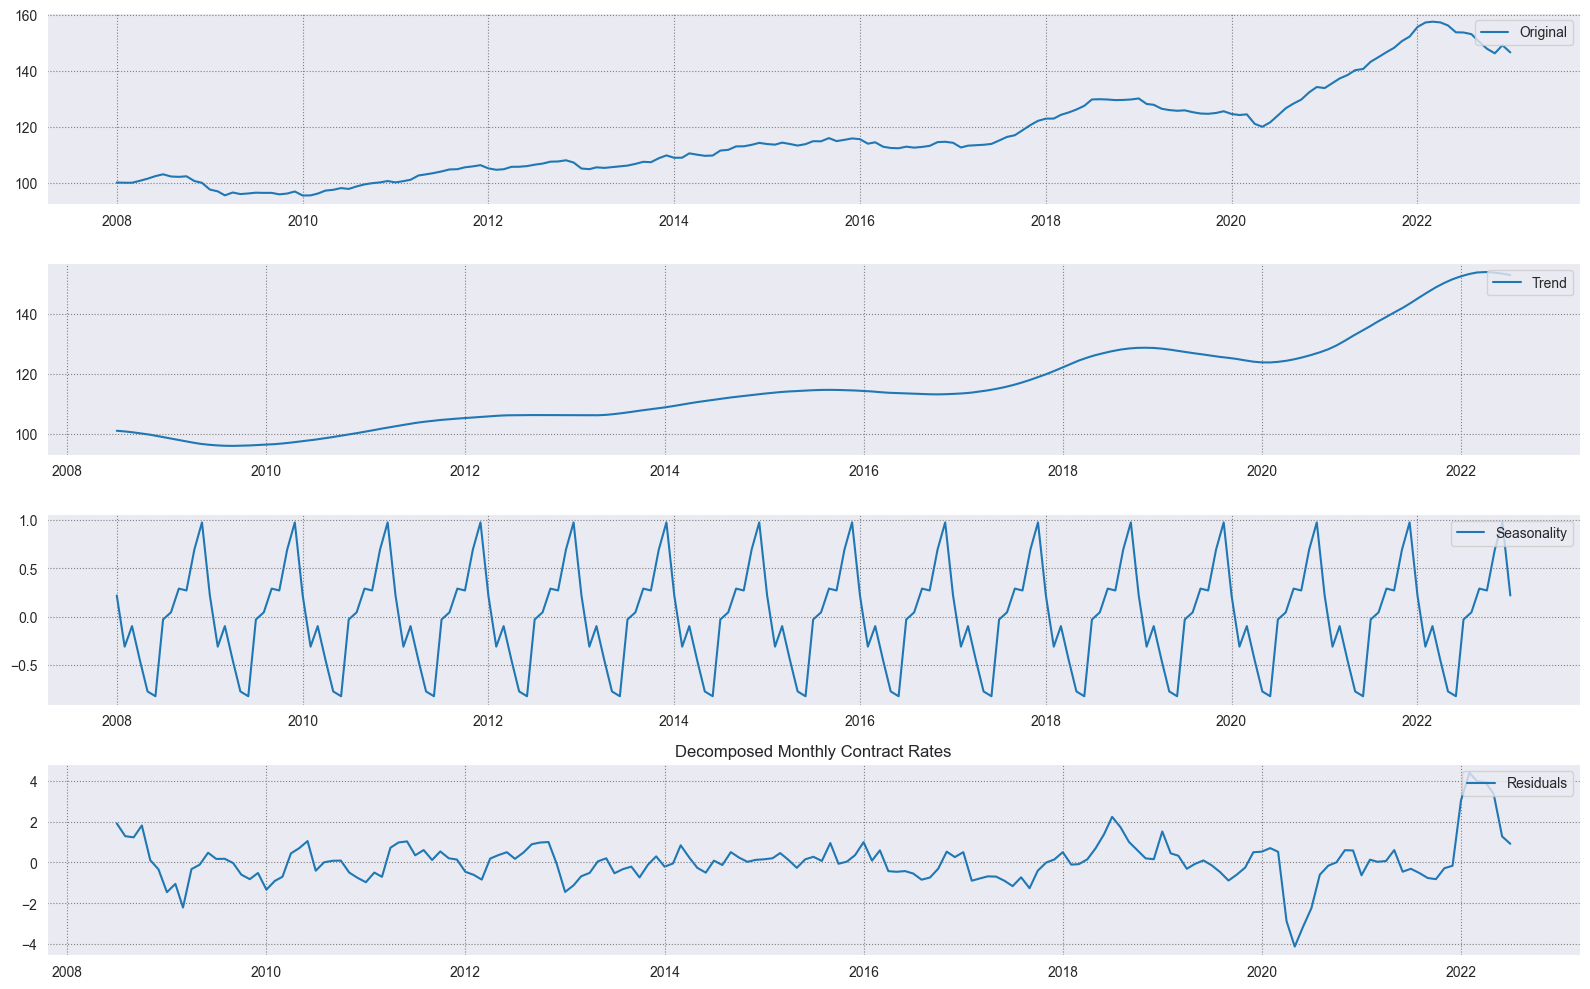

<IPython.core.display.Javascript object>

In [147]:
decompose_series(df=df_monthly[contract_col], freq="Monthly", target="Contract")

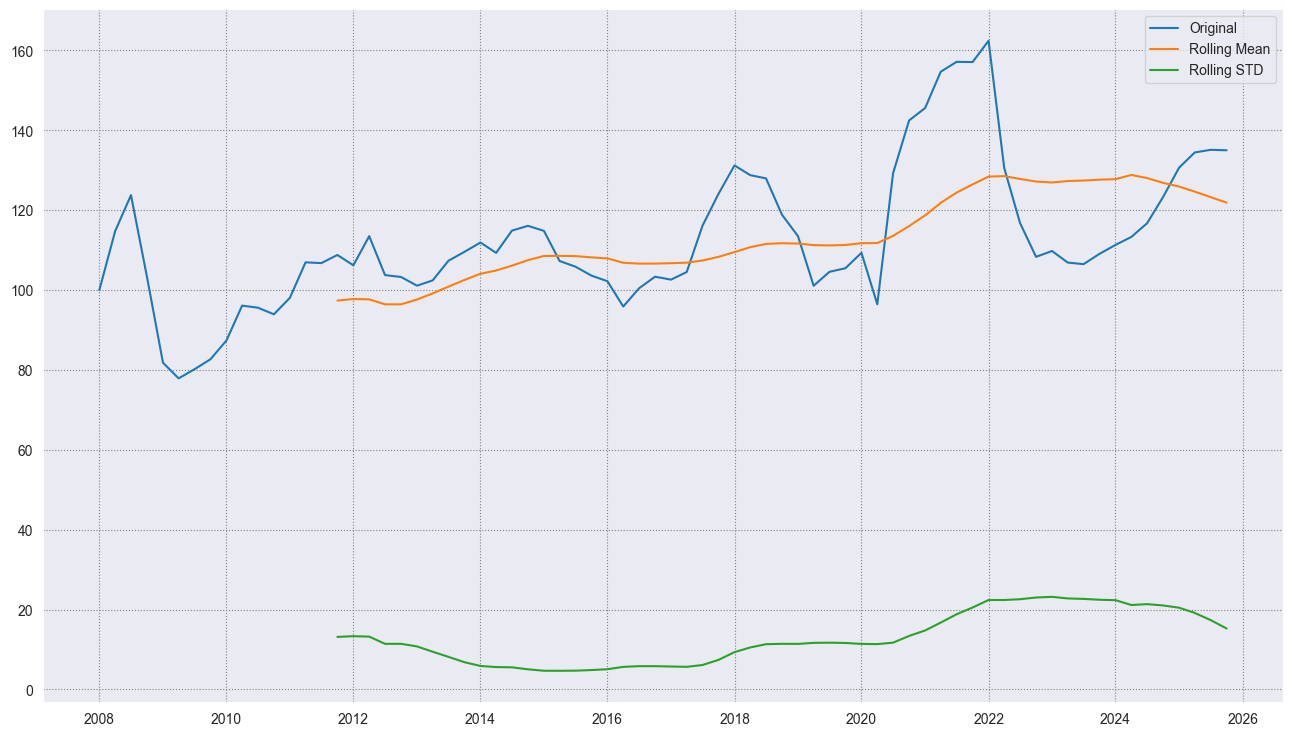

<IPython.core.display.Javascript object>

In [155]:
def plot_rolling_mean_and_std(dataframe: pd.DataFrame, window: int) -> None:
    """
    This function plots the dataframes
    rolling mean and rolling standard deviation.
    ---
    Args:
        dataframe (pd.DataFrame): Dataframe contains the timeseries
        window (int): window size
    Returns: None
    """
    df = dataframe.copy()
    # Get Things Rolling
    roll_mean = df.rolling(window=window).mean()
    roll_std = df.rolling(window=window).std()

    # Figure
    fig, ax = plt.subplots(figsize=(16, 9), facecolor="w")
    ax.plot(df, label="Original")
    ax.plot(roll_mean, label="Rolling Mean")
    ax.plot(roll_std, label="Rolling STD")

    # Legend & Grid
    ax.legend(loc="upper right")
    plt.grid(linestyle=":", color="grey")
    plt.show()


plot_rolling_mean_and_std(df_quarterly[spot_col], window=16)

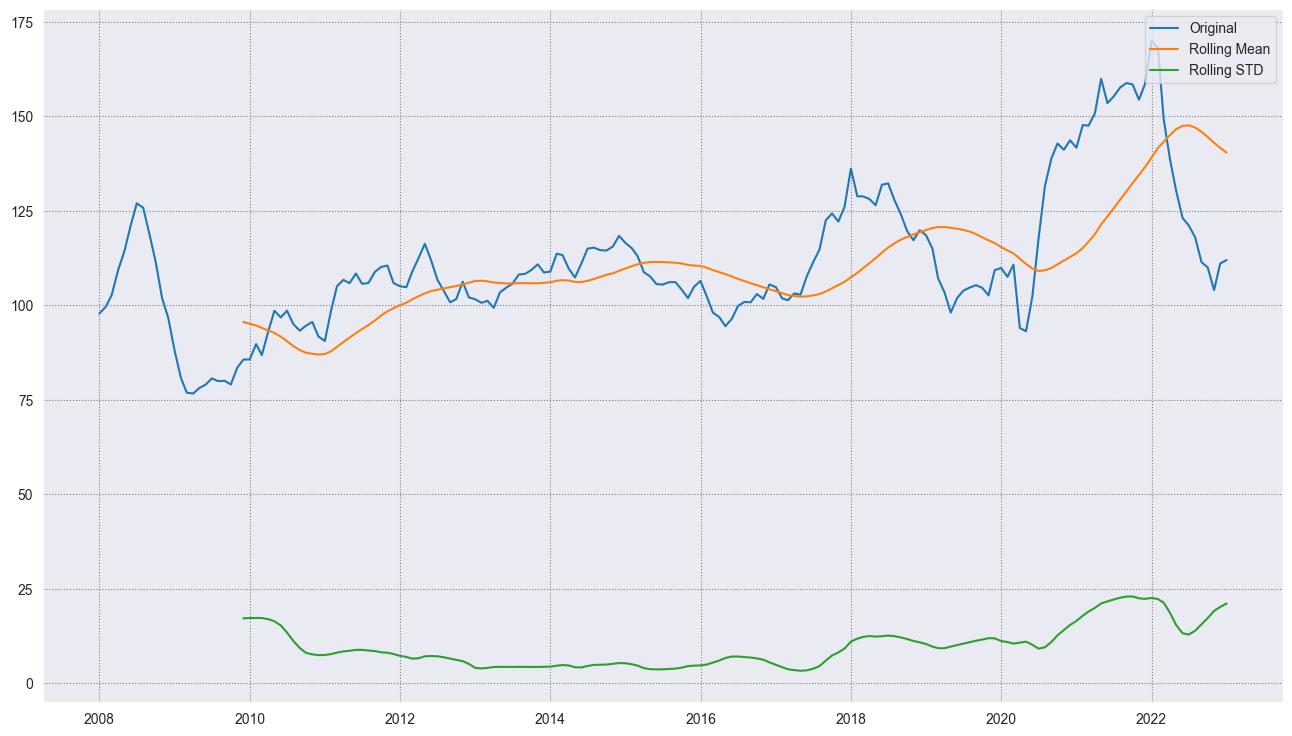

<IPython.core.display.Javascript object>

In [156]:
plot_rolling_mean_and_std(df_monthly[spot_col], window=24)

In [152]:
def perform_adf_test(df: pd.DataFrame) -> None:
    """
    Augmented Dickey Fuller Test
    - The null hypothesis for this test is that there is a unit root.
    - The alternate hypothesis is that there is no unit root in the series.
    ---
    Args:
        df (pd.DataFrame): Dataframe contains the timeseries data

    Returns: None
    """

    adf_stat, p_value, n_lags, n_observ, crit_vals, icbest = adfuller(df)

    print("\nAugmented Dickey Fuller Test")
    print("---" * 15)
    print("ADF Statistic: %f" % adf_stat)
    print("p-value: %f" % p_value)
    print(f"Number of lags used: {n_lags}")
    print(f"Number of observations used: {n_observ}")
    print(f"T values corresponding to adfuller test:")
    for key, value in crit_vals.items():
        print(key, value)


def perform_kpss_test(df: pd.DataFrame) -> None:
    """
    Kwiatkowski-Phillips-Schmidt-Shin test for stationary.
    - The null hypothesis for the test is that the data is stationary.
    - The alternate hypothesis for the test is that the data is not stationary.
    ---
    Args:
        df (pd.DataFrame): Dataframe that contains the timeseries data

    Returns: None
    """

    kpss_stat, p_value, n_lags, crit_vals = kpss(df, nlags="auto", store=False)
    print("\nKwiatkowski-Phillips-Schmidt-Shin test")
    print("---" * 15)
    print("KPSS Statistic: %f" % kpss_stat)
    print("p-value: %f" % p_value)
    print(f"Number of lags used: {n_lags}")
    print(f"Critical values of KPSS test:")
    for key, value in crit_vals.items():
        print(key, value)

<IPython.core.display.Javascript object>

In [154]:
perform_adf_test(df_monthly[spot_col])
perform_kpss_test(df_monthly[spot_col])


Augmented Dickey Fuller Test
---------------------------------------------
ADF Statistic: -2.574961
p-value: 0.098283
Number of lags used: 1
Number of observations used: 179
T values corresponding to adfuller test:
1% -3.4674201432469816
5% -2.877826051844538
10% -2.575452082332012

Kwiatkowski-Phillips-Schmidt-Shin test
---------------------------------------------
KPSS Statistic: 0.913792
p-value: 0.010000
Number of lags used: 9
Critical values of KPSS test:
10% 0.347
5% 0.463
2.5% 0.574
1% 0.739


<IPython.core.display.Javascript object>

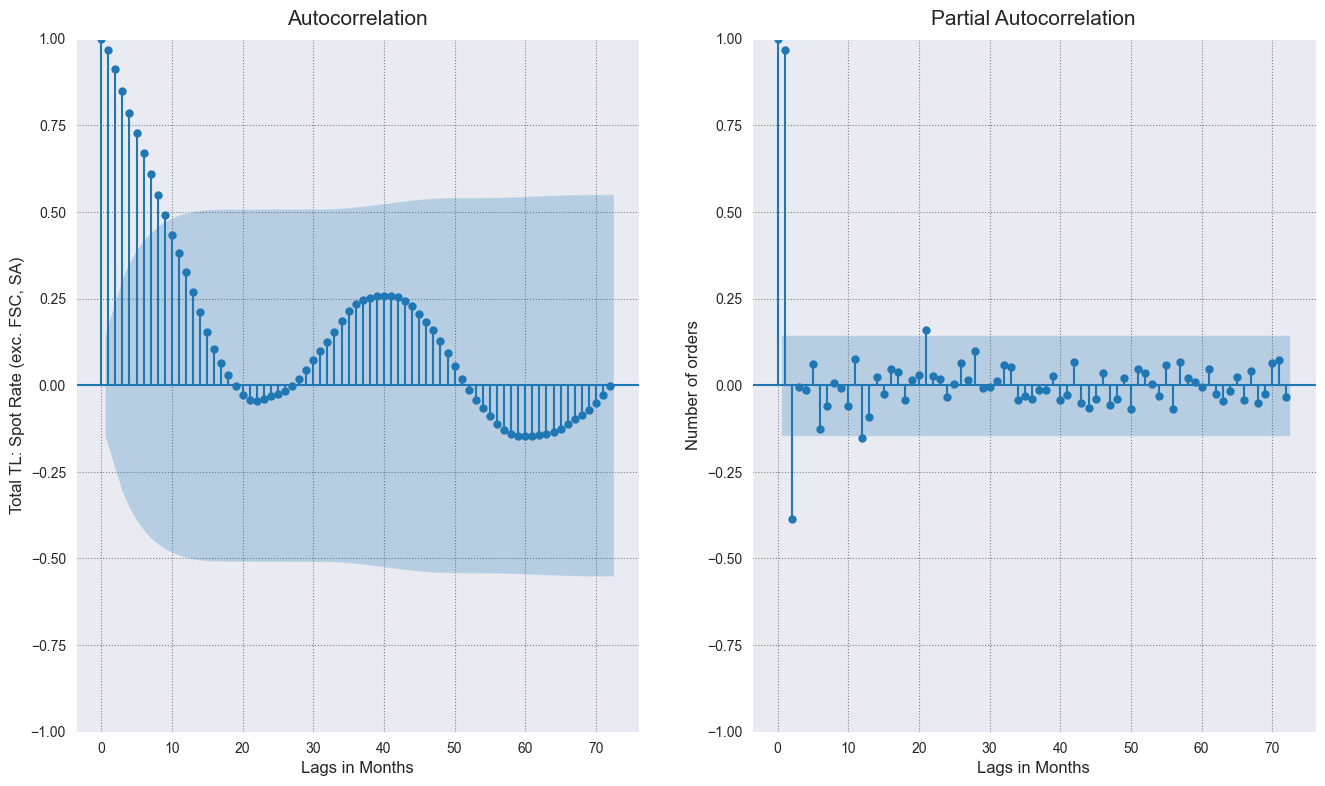

<IPython.core.display.Javascript object>

In [160]:
def plot_acf_pacf(
    df: pd.DataFrame, acf_lags: int, pacf_lags: int, target_col: str, freq: str
) -> None:
    """
    This function plots the Autocorrelation and Partial Autocorrelation lags.
    ---
    Args:
        df (pd.DataFrame): Dataframe contains the order count and dates.
        acf_lags (int): Number of ACF lags
        pacf_lags (int): Number of PACF lags
    Returns: None
    """

    # Figure
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 9), facecolor="w")

    # ACF & PACF
    plot_acf(df[target_col], ax=ax1, lags=acf_lags)
    plot_pacf(df[target_col], ax=ax2, lags=pacf_lags, method="ywm")

    # Labels
    ax1.set_title("Autocorrelation", fontsize=15, pad=10)
    ax1.set_ylabel(target_col, fontsize=12)
    ax1.set_xlabel("Lags in " + freq, fontsize=12)

    ax2.set_title("Partial Autocorrelation", fontsize=15, pad=10)
    ax2.set_ylabel("Number of orders", fontsize=12)
    ax2.set_xlabel("Lags in " + freq, fontsize=12)

    # Legend & Grid
    ax1.grid(linestyle=":", color="grey")
    ax2.grid(linestyle=":", color="grey")

    plt.show()


plot_acf_pacf(df_monthly, acf_lags=72, pacf_lags=72, freq="Months", target_col=spot_col)

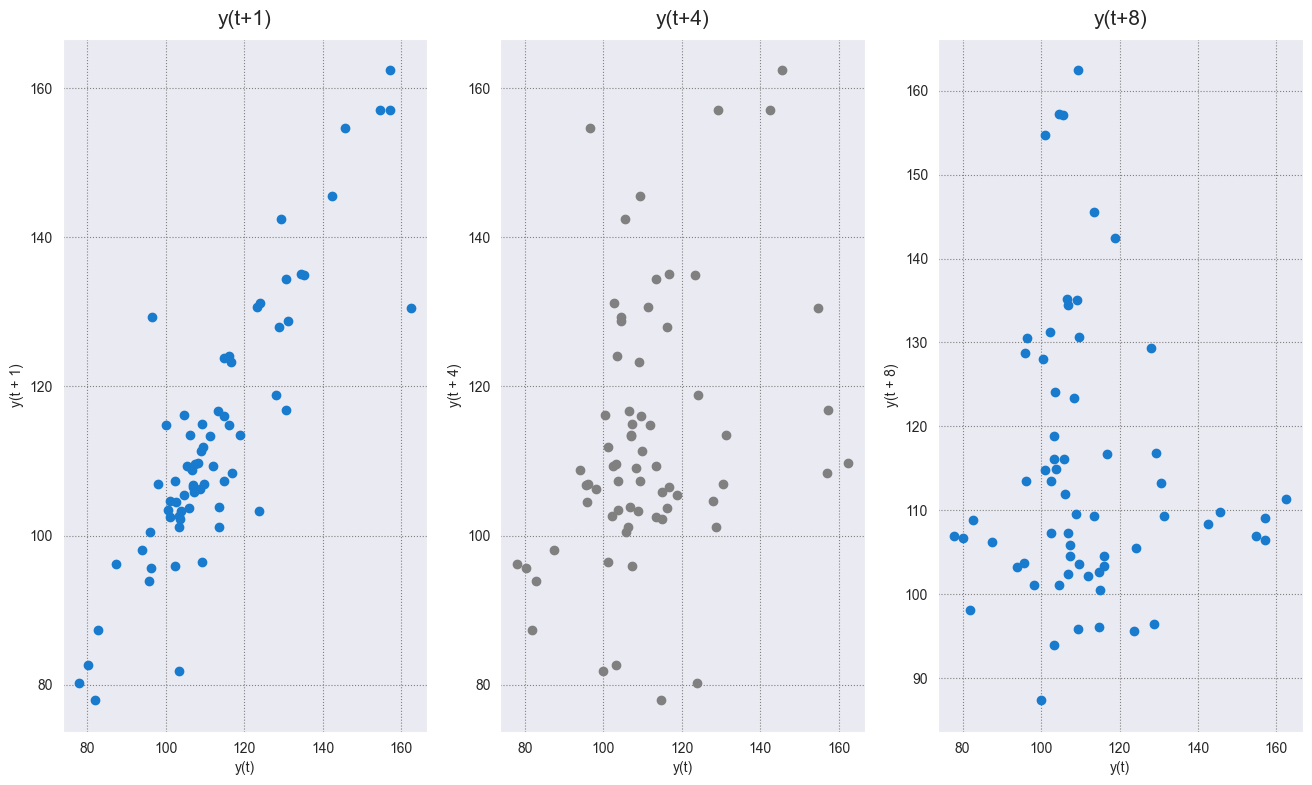

<IPython.core.display.Javascript object>

In [165]:
def lag_plots(df: pd.DataFrame, target_col: str, lags) -> None:
    """
    This function plots the correlation between
    current y(t) and y(t-1), y(t-12) and y(t-24) lags.
    ---
    Args:
        df (pd.DataFrame): Dataframe that contains a time series

    Returns: None
    """

    # Figure
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16, 9), facecolor="w")

    # Lags
    lag_plot(df[target_col], lag=lags[0], ax=ax1, c="#187bcd")
    lag_plot(df[target_col], lag=lags[1], ax=ax2, c="grey")
    lag_plot(df[target_col], lag=lags[2], ax=ax3, c="#187bcd")

    # Labels
    ax1.set_title("y(t+" + str(lags[0]) + ")", fontsize=15, pad=10)
    ax2.set_title("y(t+" + str(lags[1]) + ")", fontsize=15, pad=10)
    ax3.set_title("y(t+" + str(lags[2]) + ")", fontsize=15, pad=10)

    # Legend & Grid
    ax1.grid(linestyle=":", color="grey")
    ax2.grid(linestyle=":", color="grey")
    ax3.grid(linestyle=":", color="grey")


lag_plots(df_quarterly, target_col=spot_col, lags=[1, 4, 8])